In [36]:
pip install pandas numpy seaborn matplotlib scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\micha\appdata\local\programs\python\python311\lib\site-packages (2.2.3)




[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve
from scipy import stats
import os

In [38]:
data_path = os.path.join("..", "data", "data_DS_HW_train.csv")
df = pd.read_csv(data_path, delimiter=';',decimal=',')

Calculating the percentage of missing data in the columns

In [39]:
def missing_data(df):
    missing_percentage = 100 * df.isnull().sum()/len(df)
    missing_percentage = missing_percentage[missing_percentage > 0]
    return missing_percentage
missing_percentage = missing_data(df).sort_values()

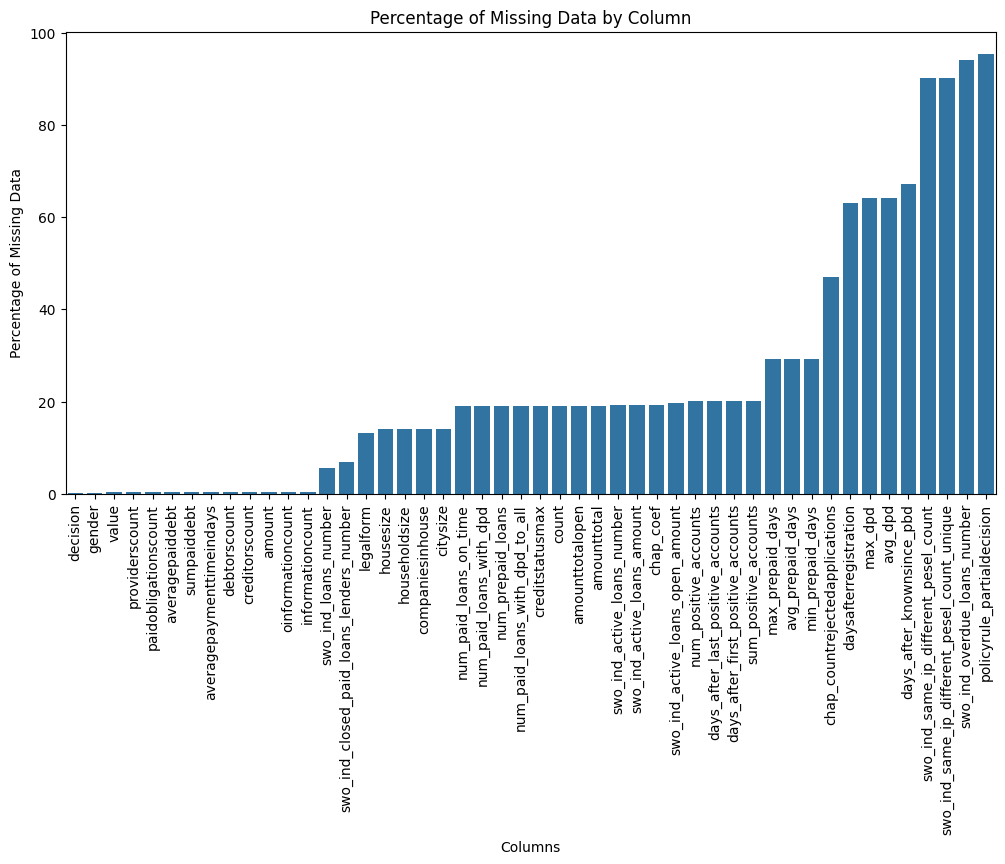

In [40]:
plt.figure(figsize=(12,6))
sns.barplot(x=missing_percentage.index, y=missing_percentage)
plt.xticks(rotation=90)
plt.title('Percentage of Missing Data by Column')
plt.ylabel('Percentage of Missing Data')
plt.xlabel('Columns')
plt.show();

This cell was used for desplaying columns with different percentage of NAs

In [41]:
print(missing_percentage[missing_percentage<5])

decision                    0.18
gender                      0.18
value                       0.33
providerscount              0.43
paidobligationscount        0.43
averagepaiddebt             0.43
sumpaiddebt                 0.43
averagepaymenttimeindays    0.43
debtorscount                0.43
creditorscount              0.43
amount                      0.43
oinformationcount           0.43
informationcount            0.43
dtype: float64


Dealing with missing Data - I dealt with NAs using different methods depending on type of data(categorical/numerical), percentage of NAs,
but also my assumptions what the columns represent

In [42]:
# Deleting the rows where NA < 1%
col_low_na = missing_percentage[missing_percentage < 1].index
df = df.dropna(axis=0, subset=col_low_na)

# Replacing NA with 0 in columns in which there is assumption based on the business intuition NA stands for 0
num_columns_to_fill = ['min_prepaid_days', 'max_prepaid_days', 'avg_prepaid_days','swo_ind_loans_number','swo_ind_closed_paid_loans_lenders_number','swo_ind_active_loans_amount','policyrule_partialdecision','swo_ind_overdue_loans_number','swo_ind_same_ip_different_pesel_count','swo_ind_same_ip_different_pesel_count_unique']
df[num_columns_to_fill] = df[num_columns_to_fill].fillna(0)

# Replacing NA with None(Lack of information might be meaningful) 
text_columns_to_fill = ['citysize','companiesinhouse','householdsize','housesize','legalform','policyrule_partialdecision']
df[text_columns_to_fill] = df[text_columns_to_fill].fillna('None')

# Marking missing numeric values and filling it with median
mark_miss_num_values = ['num_paid_loans_with_dpd_to_all','num_paid_loans_on_time','num_paid_loans_with_dpd','num_prepaid_loans','daysafterregistration','max_dpd','avg_dpd','days_after_knownsince_pbd']
for col in mark_miss_num_values:
    df[f'{col}_missing'] = df[col].isnull().astype(int)
for col in mark_miss_num_values:
    df[col] = df[col].fillna(df[col].median())

# Marking missing numeric values and filling it with 0
mark_num_values = ['amounttotal','amounttotalopen','count','creditstatusmax','num_positive_accounts','sum_positive_accounts','chap_countrejectedapplications']
for col in mark_num_values:
    df[f'{col}_missing'] = df[col].isnull().astype(int)
for col in mark_num_values:
    df[col] = df[col].fillna(0)

# The k-nearest neighbors
knn_miss_data = ['swo_ind_active_loans_amount','chap_coef','swo_ind_active_loans_amount','swo_ind_active_loans_open_amount','num_positive_accounts','sum_positive_accounts','days_after_first_positive_accounts','days_after_last_positive_accounts','swo_ind_active_loans_number']
imputer = KNNImputer(n_neighbors=5)
df[knn_miss_data] = imputer.fit_transform(df[knn_miss_data])

# Removing date
if 'loan_date_created' in df.columns:
    df = df.drop(['loan_date_created'], axis=1)

Separating features and target

In [43]:
X = df.drop(['TARGET', 'application_id'], axis=1)
y = df['TARGET']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Hot encoding categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

Dealing with outliers

In [44]:
# Calculating Z-scores
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))

# Identifing outliers
outliers = (z_scores > 3)
outliers_count = np.sum(outliers, axis=0)
outliers_per = outliers_count/len(df)

print("Percentage of outliers in each numeric column:")
print(outliers_per.sort_values().tail(10))

Percentage of outliers in each numeric column:
pesel_different_correspondence_address_count_unique_p0_1    0.055113
num_paid_loans_with_dpd_to_all                              0.056020
swo_ind_overdue_loans_number_p0_30                          0.058640
swo_ind_active_loans_number_p0_1                            0.058640
swo_ind_overdue_loans_number                                0.058640
swo_ind_overdue_loans_number_p0_plus                        0.058640
swo_ind_overdue_loans_number_p0_360                         0.058640
swo_ind_overdue_loans_number_p0_90                          0.058640
swo_ind_overdue_loans_number_p0_210                         0.058640
swo_ind_loans_number_p0_1                                   0.058841
dtype: float64


I would not remove outliers looking at the character of the data and regarding the fact I am planning to use random
forest which is not sensitive to outliers.

Splitting the Data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I tuned a RandomForest using grid_search algorithm. It took a minute so I am giving the result of a grid search below.

In [46]:
# #finding best parameters for random forest
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [20, 30, None],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2]
# }
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
#                            param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)

In [47]:
# Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}

Fitting the model

In [48]:
best_rf = RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_split=3, n_estimators=200, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

ROC Curve and AUC

Best threshold based on F1-score: 0.58


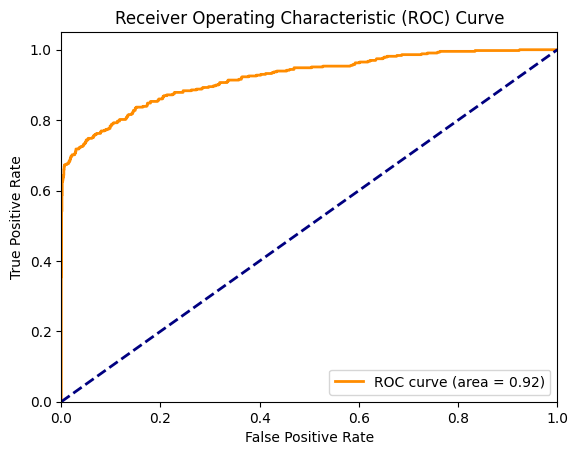

In [49]:
# Precision, recall, and thresholds
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# F1-scores for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# Finding the threshold with the maximum F1-score
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_f1_idx]

print(f"Best threshold based on F1-score: {best_threshold:.2f}")


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

AUC = 0.92 is a very good result. It means the model has a high ability to distinguish between classes.

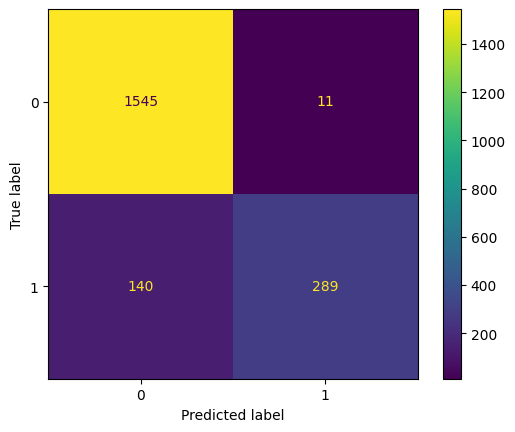


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1556
           1       0.96      0.67      0.79       429

    accuracy                           0.92      1985
   macro avg       0.94      0.83      0.87      1985
weighted avg       0.93      0.92      0.92      1985



In [50]:
# Model evaluation 
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

The threshold should be set based on the potential gain from the interest rate of the loan compared to the potential loss from defaults. This ensures that the threshold aligns with the financial trade-offs between expected revenue and the risk of loan defaults. However, due to the high threshold that maximizes the F1 score, the model rarely flags the risk of default.

Predicting values in test set

In [51]:
### Preparing test set
data_path = os.path.join("..", "data", "data_DS_HW_test.csv")
df_test = pd.read_csv(data_path, delimiter=';', decimal=',')

# Applying the same transformations to the test data
# Handling missing data (same as done for training data)
df_test[num_columns_to_fill] = df_test[num_columns_to_fill].fillna(0)
df_test[text_columns_to_fill] = df_test[text_columns_to_fill].fillna('None')

for col in mark_miss_num_values:
    df_test[f'{col}_missing'] = df_test[col].isnull().astype(int)
df_test[mark_miss_num_values] = df_test[mark_miss_num_values].fillna(df_test[mark_miss_num_values].median())

for col in mark_num_values:
    df_test[f'{col}_missing'] = df_test[col].isnull().astype(int)
df_test[mark_num_values] = df_test[mark_num_values].fillna(0)

df_test[knn_miss_data] = imputer.transform(df_test[knn_miss_data])

Separating features (no 'Target' column here)

In [52]:
X_test = df_test.drop(['application_id','loan_date_created'], axis=1)

# One-hot encoding categorical columns
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Aligning columns with training data
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

New model trained on the whole data set

In [53]:
rf_new = RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=3, n_estimators=200, random_state=42)
rf_new.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=3, n_estimators=200, random_state=42)

Making predictions

In [54]:
y_test_pred_proba = rf_new.predict_proba(X_test)[:, 1]
df_test['probability_of_default'] = y_test_pred_proba.round(3)
original_test_data = pd.read_csv(data_path, delimiter=';', decimal=',')
# loading results to csv
# result path
result_path = os.path.join("..", "result", "data_DS_HW_test_with_probabilities.csv")
pd.concat([original_test_data, df_test['probability_of_default']], axis=1).to_csv(result_path, sep=';', index=False)